<a href="https://colab.research.google.com/github/AraiKensuke/LOST/blob/master/Notebooks/AR2_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***The (implied) prior distribution when we sample from the likelihood of the AR coefficients, ie the prior is uniform over the coefficients***

In [ ]:
#@title Install LOST { form-width: "20%" }
import sys
import importlib

if importlib.util.find_spec("LOST") is None:
  %cd /content
  !git clone https://github.com/AraiKensuke/LOST.git
  %cd /content/LOST

#!python setup.py build_ext --inplace   #  don't need to compile for this notebook

sys.path.insert(1, "/content/LOST")    #  add these to searchpath for python modules

/content
Cloning into 'LOST'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (500/500), done.
remote: Compressing objects: 100% (385/385), done.
remote: Total 641 (delta 256), reused 295 (delta 111), pack-reused 141
Receiving objects: 100% (641/641), 44.66 MiB | 21.82 MiB/s, done.
Resolving deltas: 100% (327/327), done.
/content/LOST


**The oscillatory AR(2) process can be characterized using several different sets of parameterizations.**  Switching from one set to another involves a change of variables.  In Gibbs sampling, we sample parameters from the conditional posterior distribution, a combination of the conditional likelihood and prior.  Assumption of a flat prior in one set of variables does not translate to a flat prior in another due to the nonlinearity of the variable transformation.  To illustrate this, we sample uniformly from the parameter set modulus and frequency, $r$ and $f$.

(0.0, 200.0)

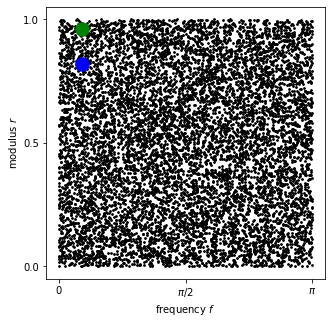

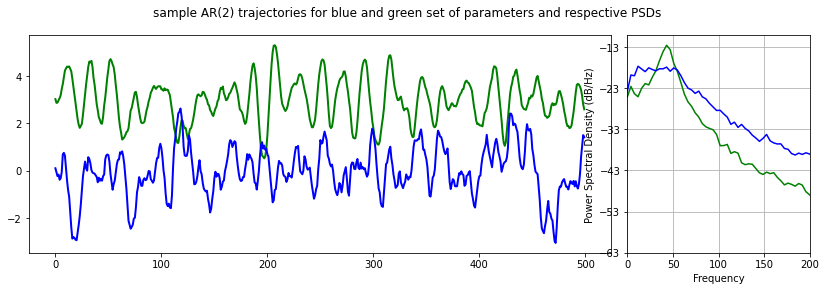

In [ ]:
#@title AR(2) parameterized by frequency and modulus (code) { form-width: "20%" }
import LOST.ARlib as _arl
from LOST.ARcfSmplFuncs import ampAngRep, buildLims, FfromLims, dcmpcff, initF
import numpy as _N
import matplotlib.pyplot as _plt
from LOST.kflib import createDataAR

#  the actual eigenvalues need | eigenvalue | < 1.  (1 / ev) > 1

k=2
N    = 10000
ra   = 0
rb   = 1

#########  imaginary roots
amps  = _N.random.rand(N) * (rb - ra) + ra
phs  = _N.random.rand(N) * _N.pi      #  phs from 0 -> pi   (well, 4pi/N, but large N->0)

#########  we'll tag 2 in 
amps[0] = 0.96
phs[0]  = 0.09 * _N.pi

amps[1] = 0.82
phs[1]  = 0.09 * _N.pi

fig = _plt.figure(figsize=(5, 5))
fig.add_subplot(1, 1, 1)
_plt.scatter(phs, amps, color="black", s=3)
_plt.scatter(phs[0:1], amps[0:1], color="green", s=180)
_plt.scatter(phs[1:2], amps[1:2], color="blue", s=180)
_plt.ylabel("modulus $r$")
_plt.yticks([0, 0.5, 1])
_plt.xticks([0, _N.pi/2, _N.pi], ["0", "$\pi/2$", "$\pi$"])
_plt.xlabel("frequency $f$")


####  transform to AR coefficients  (would've liked to do this later, but want to show AR trajectories so do it here)
####  going from (r, f) parameter set, to AR coefficients
Fsi  = _N.empty((N, 2))   #  AR(2) coefficients, imaginary roots (oscillatory)

for n in range(N):
    ph = phs[n]
    r1 = amps[n] * (_N.cos(ph) + 1j * _N.sin(ph))
    r2 = amps[n] * (_N.cos(ph) - 1j * _N.sin(ph))

    A = _N.array([[r1, 1], [r2, 1]])
    B = _N.array([[r1*r1], [r2*r2]])

    F1, F2 = _N.linalg.solve(A, B)
    F      = _N.array([F1, F2]).real
    Fsi[n, 0] = F[0]
    Fsi[n, 1] = F[1]

    # bBdd, iBdd, rts = _arl.cmplxRoots(F)
    # if not bBdd:
    #     print "Woops"

######  create sample AR trajectories for display
cohAR   = createDataAR(10000, Fsi[0], 0.1, 0, trim=0)
cohAR /= _N.std(cohAR)
incohAR = createDataAR(10000, Fsi[1], 0.1, 0, trim=0)
incohAR /= _N.std(incohAR)

fig = _plt.figure(figsize=(14, 4))
_plt.suptitle("sample AR(2) trajectories for blue and green set of parameters and respective PSDs")
_plt.subplot2grid((1, 8), (0, 0), colspan=6)
_plt.plot(cohAR[0, 0:500] + 3, color="green", lw=2)
_plt.plot(incohAR[0, 0:500], color="blue", lw=2)
_plt.subplot2grid((1, 8), (0, 6), colspan=2)
outpsd=_plt.psd(cohAR[0], Fs=1000, color="green")
#_plt.xlim(0, 200)
#_plt.subplot2grid((1, 8), (0, 6), colspan=2)
outpsd=_plt.psd(incohAR[0], Fs=1000, color="blue")
_plt.xlim(0, 200)

AR trajectories can be generated directly from the AR coefficient set $(\phi_1, \phi_2)$, which are related to the ($r$, $r$) set above by a nonlinear transformation.  It is through the AR coefficients that the generative model for the timeseries $x_t$ is expressed, and what appears in the data likelihood:  $x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + N(0, \sigma^2)$, where $\sigma^2$ is the innovation variance.  However, the AR coefficients themselves don't provide an intuitive picture of the resulting timeseries as the frequency and modulus do.  We sample different AR(2) models by sampling different sets of parameters describing the process, and it would be useful to be able to describe a prior over parameters that are directly interpretable in terms of spectral features.  To this intuitive prior into a prior over the AR(2) coefficients, we must recognize this as a change of variables.

The roots $r_1 = \alpha + i\beta$ and $r_2 = \alpha - i\beta$ of the characteristic polynomial $x^2 + \phi_2 x + \phi_1 = 0$ or the solution of $\begin{pmatrix}r_1 & 1 \\ r_2 &  1\end{pmatrix}\begin{pmatrix}\phi_1 \\ \phi_2\end{pmatrix} = \begin{pmatrix}r_1^2 \\ r_2^2\end{pmatrix}$, connect these two sets of descriptions.  
$$\alpha = \frac{\phi_1}{2}, \beta = \frac{\sqrt{-(\phi_1^2 +   4\phi_2)}}{2}$$

The modulus and angle of the roots
$$r = \sqrt{\alpha^2 + \beta^2} = \sqrt{-\phi_2}, f = \arctan \left(\frac{\beta}{\alpha}\right) = \arctan \sqrt{-\left(1 + 4\frac{\phi_2}{\phi_1^2}\right)}, \mbox{ where } f \in [0, \pi] \mbox{ and } r \in [0, 1]$$
also can be rearranged to give $\phi_1 = 2r \cos f$.  Huerta & West 1999 use $\frac{2\pi}{\lambda} = \omega$, with $\omega = 2\pi f$ to switch between wavelength (in seconds) and frequency (in Hz).  

We now examine how AR(2) parameters drawn uniform randomly in $(r, f)$ parameterization distribute in the space of AR coefficients.  Because the transformation between the parameters is nonlinear, we don't expect uniform distribution in AR(2) coefficient space.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide


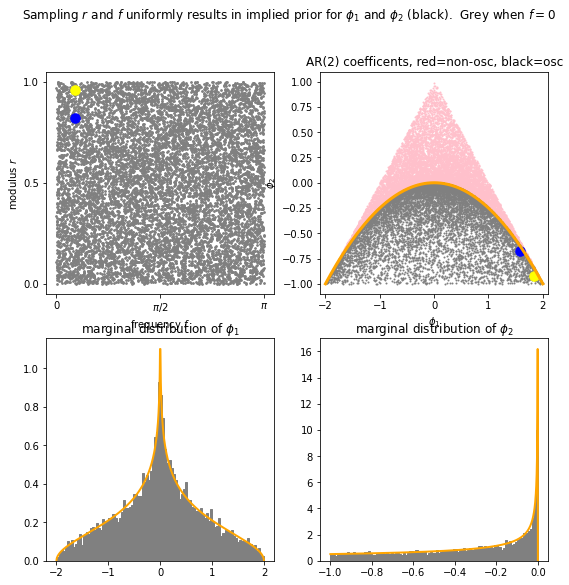

In [ ]:
#@title Modulus, frequency <--> AR coefficients  (click to show code) { form-width: "20%" }

##########  real roots
ramps = _N.random.rand(N, k) * (rb - ra) + ra
Fsr  = _N.empty((N, 2))

###  
for n in range(N):
    r1 = -1 + ramps[n, 0] * 2
    r2 = -1 + ramps[n, 1] * 2

    A = _N.array([[r1, 1], [r2, 1]])
    B = _N.array([[r1*r1], [r2*r2]])

    F1, F2 = _N.linalg.solve(A, B)
    F      = _N.array([F1, F2])
    Fsr[n, 0] = F[0]
    Fsr[n, 1] = F[1]

#    bBdd, iBdd, rts = _arl.cmplxRoots(F)
#    if not bBdd:
#        print "Woops"

###  Now we take a look at what the marginal distribution of phi_1 and phi_2
###  look like when we sample r and f uniformly.
x = _N.linspace(-2, 2, 201)
#y = 0.25*(4 - x**2) - 1
y = -0.25*x**2
    
#  rts == (1./(r1*r1.conjugate())), (1./(r1*r1.conjugate()))
fig = _plt.figure(figsize=(9, 9))
_plt.suptitle("Sampling $r$ and $f$ uniformly results in implied prior for $\phi_1$ and $\phi_2$ (black).  Grey when $f=0$")
fig.add_subplot(2, 2, 1)
_plt.scatter(phs, amps, color="grey", s=3)
_plt.scatter(phs[0:1], amps[0:1], color="yellow", s=90)
_plt.scatter(phs[1:2], amps[1:2], color="blue", s=90)
_plt.ylabel("modulus $r$")
_plt.yticks([0, 0.5, 1])
_plt.xticks([0, _N.pi/2, _N.pi], ["0", "$\pi/2$", "$\pi$"])
_plt.xlabel("frequency $f$")
fig.add_subplot(2, 2, 2)
_plt.title("AR(2) coefficents, red=non-osc, black=osc")
_plt.scatter(Fsr[:, 0], Fsr[:, 1], marker=".", s=4, color="pink")
_plt.grid()
_plt.xlim(-2.5, 2.5)
_plt.ylim(-1.5, 1.5)
_plt.scatter(Fsi[:, 0], Fsi[:, 1], marker=".", s=4, color="grey")
_plt.scatter(Fsi[0:1, 0], Fsi[0:1, 1], color="yellow", s=90)
_plt.scatter(Fsi[1:2, 0], Fsi[1:2, 1], color="blue", s=90)
_plt.plot(x, y, color="orange", lw=3)
_plt.grid()
_plt.xlim(-2.1, 2.1)
_plt.ylim(-1.1, 1.1)
_plt.xlabel(r"$\phi_1$")
_plt.ylabel(r"$\phi_2$")

fig.add_subplot(2, 2, 3)
_plt.title("marginal distribution of $\phi_1$")
phi1s = _N.linspace(-2, 2, 1001, endpoint=True)
suppress = _plt.hist(Fsi[:, 0], bins=_N.linspace(-2, 2, 101), color="grey", edgecolor="grey", density=True)
p_phi1 = _N.log(_N.sqrt(4/phi1s**2) + _N.sqrt(-1 + 4/phi1s**2))
p_phi1[500] = p_phi1[499]
p_phi1[0]   = 0
p_phi1[-1]  = 0
A = _N.sum(p_phi1 * (phi1s[1] - phi1s[0]))
_plt.plot(phi1s, p_phi1/A, color="orange", lw=2)
fig.add_subplot(2, 2, 4)
_plt.title("marginal distribution of $\phi_2$")
suppress = _plt.hist(Fsi[:, 1], bins=_N.linspace(-1, 0, 101), color="grey", edgecolor="grey", density=True)
phi2s = _N.linspace(-1, 0, 1001, endpoint=True)
p_phi2 = 1/_N.sqrt(-phi2s)
p_phi2[-1] = 0
A = _N.sum(p_phi2 * (phi2s[1] - phi2s[0]))
_plt.plot(phi2s, p_phi2/A, color="orange", lw=2)


The black dots don't appear uniformly distributed in the stationary AR(2) region - it looks more dense near the orange boundary between oscillatory and non-oscillatory AR(2) coefficents.  How the probability distribution change from one space to the next can be calculated using change of variables formula for joint distributions: $p(r, f) = J(r, f; \phi_1, \phi_2) p(\phi_1, \phi_2)$.

In Huerta and West 1999, an example is given for the parameter set $(r, \lambda)$ where $\lambda = 1/f$.  The change of variable formula $\phi_1 = 2r \cos\left(\frac{2\pi}{\lambda}\right)$ and $\phi_2 = -r^2$.  The above marginals for $\lambda$ and $r$ can be derived by looking at the Jacobian,
$$\det\begin{pmatrix}\frac{\partial F_1}{\partial r}  & \frac{\partial F_1}{\partial 
\lambda} \\ \frac{\partial F_2}{\partial r} & \frac{\partial F_2}{\partial \lambda}\end{pmatrix} 
= 
\det\begin{pmatrix}2 \cos\left(\frac{2\pi}{\lambda}\right)  & \frac{2r \sin\left(\frac{2\pi}{\lambda}\right)}{\lambda^2} \\ -2r & 0\end{pmatrix} 
= 
-\frac{4r^2 \sin\left(\frac{2\pi}{\lambda}\right)}{\lambda^2}$$.  The marginals $p(r) \propto r^2$ and $h(\lambda) \propto \frac{\sin\left(\frac{2\pi}{\lambda}\right)}{\lambda^2}$, in agreement with Huerta & West 1999.

We are interested in building a flat prior in frequency space, so we consider 
For the reverse transformation, mult by 2: hypotenuse=$2\sqrt{-F_2}$, opposite=$\sqrt{-(F_1^2 + 4F_2)}$, adjacent=$F_1$. 

$$\det\begin{pmatrix}\frac{\partial r}{\partial F_1}  & \frac{\partial r}{\partial 
F_2} \\ \frac{\partial f}{\partial F_1} & \frac{\partial f}{\partial F_2}\end{pmatrix} 
= 
\det\begin{pmatrix}0  & -\frac{1}{2\sqrt{-\phi_2}} \\ -\frac{1}{\sqrt{-\phi_1^2 - 4\phi_2}} & \frac{\phi_1}{2\phi_2\sqrt{-(\phi_1^2 + 4\phi_2)}}\end{pmatrix} 
= 
\frac{1}{\sqrt{-\phi_2}\sqrt{-\phi_1^2 - 4\phi_2}}.$$  

Unlike for $r$ and $\lambda$, $F_1$ and $F_2$ are constrained in what values they can take, so we must marginalize:

$$
p(\phi_1) = \int_{-1}^{-\frac{\phi_1^2}{4}} \frac{1}{\sqrt{-\phi_2}\sqrt{-\phi_1^2 - 4\phi_2}} d\phi_2 = \log \left| 
\sqrt{\frac{4}{\phi_1^2}} + \sqrt{-1 + \frac{4}{\phi_1^2}}\right|
$$
$$
p(\phi_2) = \frac{1}{\sqrt{-\phi_2}}\int_{-\sqrt{-4\phi_2}}^{\sqrt{-4\phi_2}} \frac{1}{\sqrt{-\phi_1^2 - 4\phi_2}} d\phi_1 = \frac{2\pi}{\sqrt{-\phi_2}}
$$



Text(0.5, 0, '$\\lambda$')

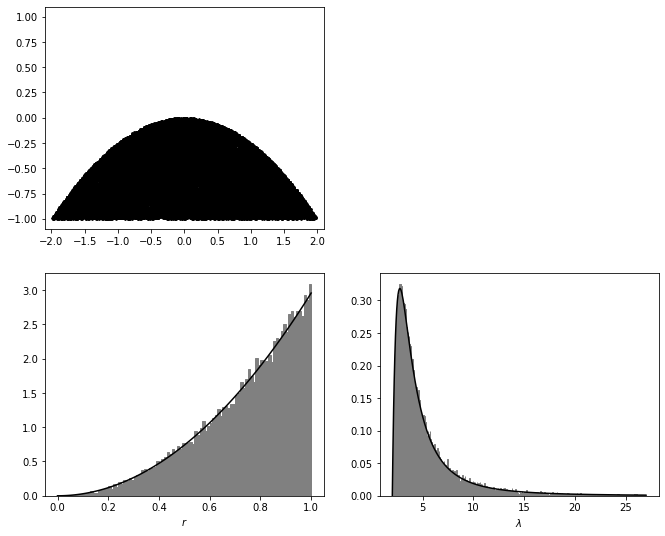

In [ ]:
#  Sample oscillatory AR(2) coefficients

#  First sample uniform [-2, 2] x [-2, 2]
#  Reject if c2 < 0.25*(4-c1**2)-1 or c2 > c1+1 if c1 < 0 
#   or c2 > -c1 + 1 if c1 > 0

N = 100000
c12_cands = _N.empty((N, 2))
c12_cands[:, 0] = 4*(_N.random.rand(N)-0.5)
c12_cands[:, 1] = 2*(_N.random.rand(N)-0.5)

c12 = []
for n in range(N):
    c1 = c12_cands[n, 0]
    c2 = c12_cands[n, 1]

    upper_c2 = 0.25*(4 - c1*c1)-1

    bad = False
    if c2 > upper_c2:
        bad = True
        
    if not bad:
        c12.append([c1, c2])


c12s = _N.array(c12)

#  AR coefficients
#  modulus and angle
#  roots

#  here, I want to turn AR coefficient into modulus and angle pair


Fs=1000
amps = _N.zeros(c12s.shape[0])
fs   = _N.zeros(c12s.shape[0])

#  lambda_u   is n/2 for data length n
#  lambda
for n in range(c12s.shape[0]):
    bBdd, iBdd, mag, F_alfa_rep = _arl.ARroots(_N.array([c12s[n, 0], c12s[n, 1]]))
    prt, rank, f, amp = ampAngRep(F_alfa_rep, 1./(Fs/2), f_order=True)
    amps[n] = amp[0]
    fs[n] = f[0]

#  
#  my fs is between 0 and 1.  lambda is between [2, lambda_u].
#  w = 2pi / lam, so w from 2pi/2=pi   to   2pi/ (N/2) = 4pi/N -> 0
#  w 2pi / 2   pi  to    2pi/(N/2) = 4pi/N

w = fs*_N.pi   
lam = 2*_N.pi / w

fig = _plt.figure(figsize=(11, 9))
fig.add_subplot(2, 2, 1)
_plt.scatter(c12s[:, 0], c12s[:, 1], s=3, color="black")
_plt.xlim(-2.1, 2.1)
_plt.ylim(-1.1, 1.1)
fig.add_subplot(2, 2, 3)
amps_x = _N.linspace(0, 1, 101)
dx = amps_x[1] - amps_x[0]
_plt.hist(amps, bins=_N.linspace(0, 1, 101), color="grey", edgecolor="grey", density=True)
A = _N.sum(amps_x*amps_x*dx)
_plt.plot(amps_x, (1/A) *  amps_x * amps_x, color="black")
_plt.xlabel("$r$")
fig.add_subplot(2, 2, 4)
#lam_x = _N.linspace(2, 52, 101)
lam_x = _N.linspace(2, 27, 401)
dx    = lam_x[1] - lam_x[0]
hist_out = _plt.hist(lam, bins=lam_x, density=True, color="grey", edgecolor="grey")
A = _N.sum((_N.sin(2*_N.pi/lam_x) / (lam_x*lam_x))*dx)
_plt.plot(lam_x, (1/A)*_N.sin(2*_N.pi/lam_x) / (lam_x*lam_x), color="black")
_plt.xlabel("$\lambda$")

What's being proposed here:

We're sampling $\phi_2$ first.  We'll do this the current way.  This leads to a prior $p(r) \propto r^2$.  We then sample $\phi_1$, which is a truncated Gaussian.  We'll multiply this by $p(\phi_1 | \phi_2)$.  

Compare scatter of our sampled AR coefficients to the scatter in $(r, f)$ space.

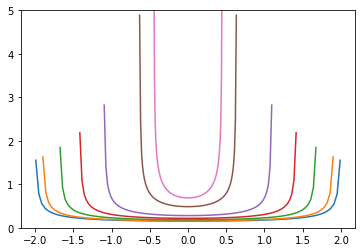

In [29]:
#  conditional prior, since we actually want a joint prior

for phi2 in [-0.99, -0.9, -0.7, -0.5, -0.3, -0.1, -0.05]:
    phi1s = _N.linspace(-_N.sqrt(-4*phi2), _N.sqrt(-4*phi2), 101)
    pr_phi1[1:-1] = 1 / (_N.sqrt(-phi2) * _N.sqrt(-phi1s[1:-1]**2 - 4*phi2))
    
    pr_phi1[0] = pr_phi1[1]*2
    pr_phi1[-1] = pr_phi1[-2]*2
    dx = phi1s[1] - phi1s[0]
    A = _N.sum(pr_phi1*dx)
    _plt.plot(phi1s, pr_phi1/A)
    _plt.ylim(0, 5)
